In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)

TF version: 2.19.0


Load a lightweight dataset (no downloads)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train.shape, X_test.shape

((455, 30), (114, 30))

Helper: build/train/evaluate models quickly

In [4]:
def build_mlp(input_dim, hidden_units=[32, 16], dropout=0.0, l2=0.0, lr=1e-3):
    reg = keras.regularizers.l2(l2) if l2 > 0 else None

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for u in hidden_units:
        model.add(layers.Dense(u, activation="relu", kernel_regularizer=reg))
        if dropout > 0:
            model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

def train_and_eval(config, X_train, y_train, X_test, y_test, epochs=12, batch_size=32):
    tf.keras.backend.clear_session()

    model = build_mlp(
        input_dim=X_train.shape[1],
        hidden_units=config["hidden_units"],
        dropout=config["dropout"],
        l2=config["l2"],
        lr=config["lr"]
    )

    early = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early],
        verbose=0
    )

    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    return model, history, acc, f1, y_pred

## Define lightweight experiments (rubric-friendly)

Baseline, Dropout ,L2 regularization, Lower LR

In [5]:
experiments = [
    {"name": "baseline", "hidden_units": [32,16], "dropout": 0.0, "l2": 0.0, "lr": 1e-3},
    {"name": "dropout_0.3", "hidden_units": [32,16], "dropout": 0.3, "l2": 0.0, "lr": 1e-3},
    {"name": "l2_1e-3", "hidden_units": [32,16], "dropout": 0.0, "l2": 1e-3, "lr": 1e-3},
    {"name": "low_lr_1e-4", "hidden_units": [32,16], "dropout": 0.0, "l2": 0.0, "lr": 1e-4},
]

results = []
histories = {}
preds = {}

for cfg in experiments:
    model, history, acc, f1, y_pred = train_and_eval(cfg, X_train, y_train, X_test, y_test)
    histories[cfg["name"]] = history.history
    preds[cfg["name"]] = y_pred

    results.append({
        "experiment": cfg["name"],
        "hidden_units": str(cfg["hidden_units"]),
        "dropout": cfg["dropout"],
        "l2": cfg["l2"],
        "lr": cfg["lr"],
        "test_accuracy": acc,
        "test_f1": f1
    })

results_df = pd.DataFrame(results).sort_values("test_f1", ascending=False)
results_df

,experiment,hidden_units,dropout,l2,lr,test_accuracy,test_f1
1,dropout_0.3,"[32, 16]",0.3,0.000,0.0010,0.956140,0.965517
2,l2_1e-3,"[32, 16]",0.0,0.001,0.0010,0.956140,0.965035
0,baseline,"[32, 16]",0.0,0.000,0.0010,0.947368,0.957746
3,low_lr_1e-4,"[32, 16]",0.0,0.000,0.0001,0.885965,0.909091


Plot training curves (loss + accuracy)

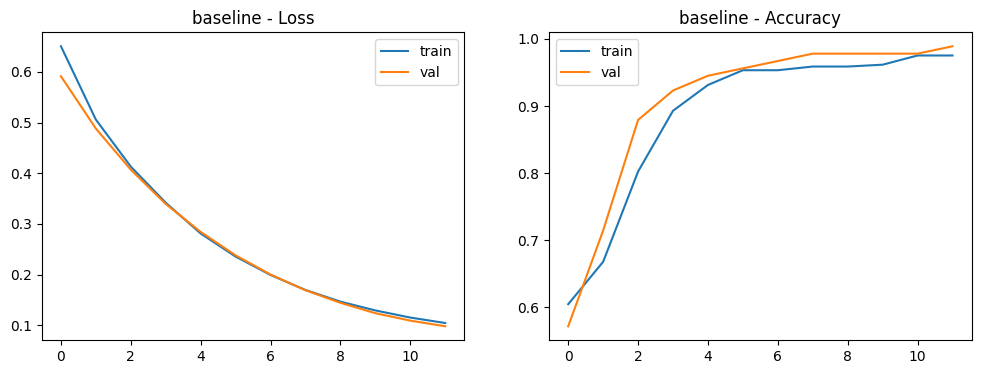

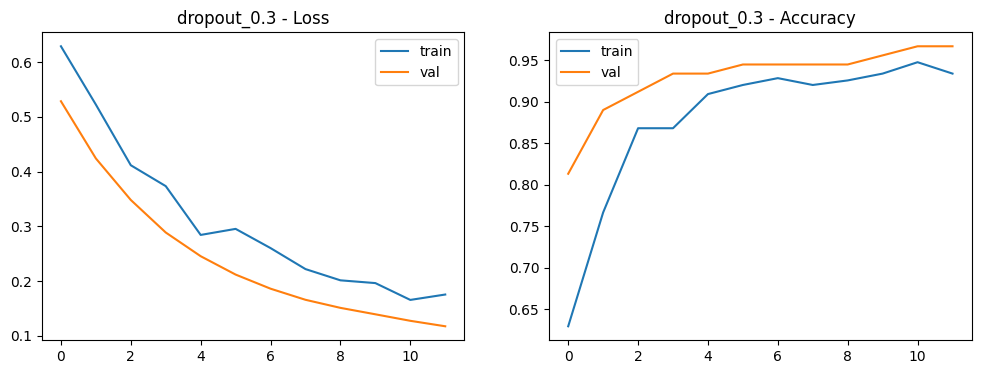

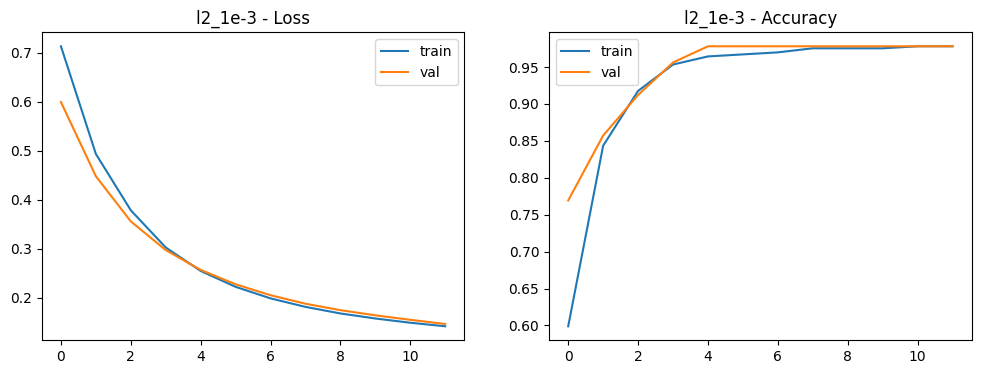

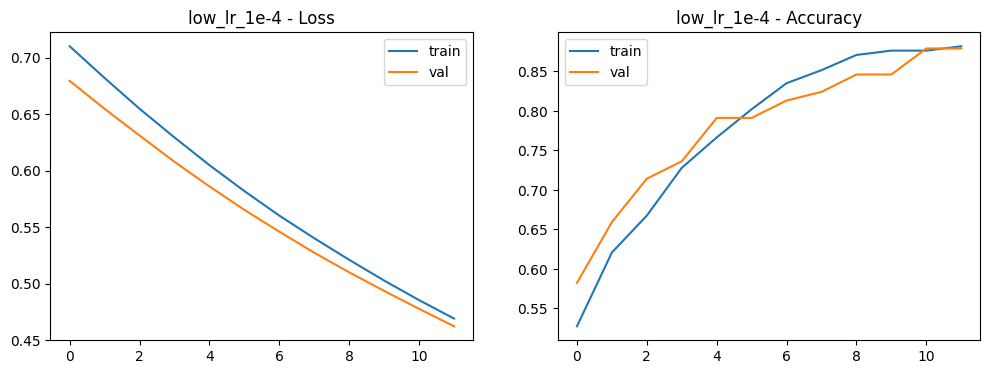

In [6]:
def plot_history(hist, title):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(hist["loss"], label="train")
    ax[0].plot(hist["val_loss"], label="val")
    ax[0].set_title(f"{title} - Loss")
    ax[0].legend()

    ax[1].plot(hist["accuracy"], label="train")
    ax[1].plot(hist["val_accuracy"], label="val")
    ax[1].set_title(f"{title} - Accuracy")
    ax[1].legend()
    plt.show()

for name, hist in histories.items():
    plot_history(hist, name)

Confusion matrix + classification report for best model

In [7]:
best_name = results_df.iloc[0]["experiment"]
print("Best experiment:", best_name)

y_pred_best = preds[best_name]
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

cm = confusion_matrix(y_test, y_pred_best)
cm

Best experiment: dropout_0.3
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



array([[39,  3],
       [ 2, 70]])

Saving outputs for GitHub submission

In [9]:
import os, json

os.makedirs("artifacts_ann", exist_ok=True)

# Save results table
results_df.to_csv("artifacts_ann/ann_results.csv", index=False)

# Save best model
# retrain quickly using best config to save model cleanly
best_cfg = [c for c in experiments if c["name"] == best_name][0]
best_model = build_mlp(X_train.shape[1], best_cfg["hidden_units"], best_cfg["dropout"], best_cfg["l2"], best_cfg["lr"])
best_model.fit(X_train, y_train, validation_split=0.2, epochs=12, batch_size=32, verbose=0)
best_model.save("artifacts_ann/best_ann_model.keras")

# Save scaler params (for inference later)
np.save("artifacts_ann/scaler_mean.npy", scaler.mean_)
np.save("artifacts_ann/scaler_scale.npy", scaler.scale_)

print("Saved artifacts in artifacts_ann/")

Saved artifacts in artifacts_ann/
